# YNK forecast

## Import data

In [57]:
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve,auc
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [51]:
# Import data in csv from github

# Import data from github
url = 'https://raw.githubusercontent.com/sagebhardt/forecast-AI-ynk/main/Base%20Analisis%20-%20Prueba%2001.1%20Forecasting%20en%20Belsport%20(Venta%20y%20Stock%20por%20marca%20y%20catergoria).csv'
df = pd.read_csv(url, sep=';')

# Remove '$' from column names
df.columns = df.columns.str.replace('$', '')

#print df size
print(df.shape)

df.head()

(54531, 11)


/var/folders/7n/r8rrh9ss6q9b_lyhlmx1x_hw0000gn/T/ipykernel_86404/173362198.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace('$', '')


,Semana,Tienda,Tipo mat,Grupo articulos,Sexo,Age Group,Entradas Tienda,Venta U,Venta Bruta,Costo Neto,Stock
0,W01,01-Ahumada,ZAPP,AD,Male,Adult,6857,2,46790,23194,89.0
1,W01,01-Ahumada,ZAPP,NI,Female,Adult,6857,1,26990,12520,118.0
2,W01,01-Ahumada,ZAPP,NI,Female,Pre School + Grade School,6857,3,73680,34777,18.0
3,W01,01-Ahumada,ZAPP,NI,Male,Adult,6857,19,593950,285666,270.0
4,W01,01-Ahumada,ZAPP,NI,Male,Grade School,6857,2,38980,18083,136.0


## Clean data  

In [52]:
#check for missing values
df.isnull().sum()

Semana                 0
Tienda                 0
Tipo mat               0
Grupo articulos        0
Sexo                1389
Age Group           1793
Entradas Tienda        0
Venta U                0
Venta Bruta            0
Costo Neto             0
Stock              16906
dtype: int64

In [53]:
#split features into categorical and numerical
categorical_features = df.select_dtypes(include=['object']).columns
numerical_features = df.select_dtypes(exclude=['object']).columns

print(categorical_features)
print(numerical_features)

Index(['Semana', 'Tienda', 'Tipo mat', 'Grupo articulos', 'Sexo', 'Age Group'], dtype='object')
Index(['Entradas Tienda', 'Venta U', 'Venta Bruta ', 'Costo Neto ', 'Stock'], dtype='object')


In [46]:
df_cat = pd.get_dummies(df[categorical_features], drop_first = True, dummy_na = True)
df_num = df[numerical_features]

from sklearn.impute import SimpleImputer
imp_num = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0, verbose=1, copy=True)
imp_num.fit(df_num)
df_num = pd.DataFrame(imp_num.transform(df_num), columns = df_num.columns)

df_binned = pd.concat([df_num, df_cat], axis = 1)

print(df_binned.shape)

df_binned.head()

(54531, 121)


/Users/sebage/opt/anaconda3/envs/cv/lib/python3.10/site-packages/sklearn/impute/_base.py:382: FutureWarning: The 'verbose' parameter was deprecated in version 1.1 and will be removed in 1.3. A warning will always be raised upon the removal of empty columns in the future version.
  warnings.warn(


,Entradas Tienda,Venta U,Venta Bruta,Costo Neto,Stock,Semana_W02,Semana_W03,Semana_W04,Semana_W05,Semana_W06,...,Sexo_Male,Sexo_Unisex,Sexo_nan,Age Group_Adult,Age Group_Full Family,Age Group_Grade School,Age Group_Pre School,Age Group_Pre School + Grade School,Age Group_Toddler,Age Group_nan
0,6857.0,2.0,46790.0,23194.0,89.0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1,6857.0,1.0,26990.0,12520.0,118.0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,6857.0,3.0,73680.0,34777.0,18.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,6857.0,19.0,593950.0,285666.0,270.0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,6857.0,2.0,38980.0,18083.0,136.0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0


In [55]:
#Get features and target
y = df_binned['Venta Bruta ']
X = df_binned.drop(['Venta Bruta ', 'Venta U', 'Costo Neto '], axis = 1)

features = X.columns


## Test Models

## 5-Fold Cross Validation

In [58]:
def rmse(actual,prediction):
    residuals = actual-prediction
    return (np.sqrt(np.mean( residuals**2  )))

nFolds = 5

kf = KFold(n_splits=nFolds, random_state=None, shuffle=True)

RMSEList = pd.DataFrame(columns = ['GBM_RMSE','XGB_RMSE','CATBOOST_RMSE'])
RMSEList.GBM_RMSE = np.zeros(nFolds)
RMSEList.XGB_RMSE = np.zeros(nFolds)
RMSEList.CATBOOST_RMSE = np.zeros(nFolds)


i=0
for train_index, valid_index in kf.split(df_binned):
    
    train_cv = df_binned.iloc[train_index,:]
    valid_cv = df_binned.iloc[valid_index,:]
    
    # GBM Model
    modelGBM = GradientBoostingClassifier(n_estimators=154) #n_estimators denotes the number of trees that are constructed 155
    GBtrain_cv = modelGBM.fit(train_cv.loc[:,features],train_cv['Venta Bruta '])
    validProbsGB_cv  = GBtrain_cv.predict(valid_cv.loc[:,features])[:,1]
    RMSEList.GBM_RMSE[i]= rmse(valid_cv['Venta Bruta '], validProbsGB_cv)  
    
    # XGB Model
    XGBtraining = xgb.DMatrix(train_cv.loc[:,features], train_cv['Venta Bruta '])
    XGBvalidation = xgb.DMatrix(valid_cv.loc[:,features], valid_cv['Venta Bruta '])

    XGBparam = {'max_depth':6, 'eta': 0.02, 'objective': 'binary:logistic', 'min_child_weight': 1}
    XGBparam['nthread'] = -1
    XGBparam['eval_metric'] = 'rmse'
    XGBparam['seed'] = 0
    XGBparam['colsample_bytree'] = 0.5
    XGBparam['subsample']=0.5
    evallist = [(XGBtraining, 'train'), (XGBvalidation, 'eval')]

    num_round = 215 # This is the number of iterations (trees) that are constructed
    modelXGB = xgb.train(XGBparam, XGBtraining,num_round)
    validationProbsXGB = modelXGB.predict(XGBvalidation)

    RMSEList.XGB_RMSE[i]= rmse(valid_cv['Venta Bruta '], validationProbsXGB)  
    
    
    # CatBoost Model
    
    modelCB = CatBoostClassifier(iterations=1000, learning_rate=0.069, depth=6, loss_function='Logloss', eval_metric='AUC', random_seed=32, od_type='Iter', metric_period=50)
    modelCB.fit(train_cv.loc[:,features],train_cv['Venta Bruta '], 
                eval_set=(valid_cv.loc[:,features],valid_cv['Venta Bruta ']),
                use_best_model=True, verbose=True)

    #predict on test set
    probsCB=modelCB.predict(valid_cv.loc[:,features])[:,1]

    RMSEList.CATBOOST_RMSE[i]= rmse(valid_cv['Venta Bruta '], probsCB)  
    
    i = i + 1
    print('Finished fold',i)

KeyboardInterrupt: 

# PCA Analysis

In [6]:
import numpy as np

max_chunk = 100

print('Data shape =',df.shape)

# Get 200 rows only, and also taking the text column
df = df.loc[0:500,:]

max_text_len = df['Description'].apply(lambda x:len(x)).max()
print('max text length = ',max_text_len)

Data shape = (134325, 23)
max text length =  40


In [7]:
def get_max_len(tokenized):
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)
    return max_len

def process_chunk(dtf_chunk):
    import transformers as ppb
    import torch
    
    #model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
    model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)
    
    tokenized = dtf_chunk['Description'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
    
    max_len = get_max_len(tokenized)
    
    if (max_len > 512):
        print('Chunk has',max_len,'tokens,..., Aborting.')
        features = -1
    else: 
        padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
        attention_mask = np.where(padded != 0, 1, 0)
        input_ids = torch.tensor(padded)
        attention_mask = torch.tensor(attention_mask)
        with torch.no_grad():
            last_hidden_states = model(input_ids, attention_mask=attention_mask)
        features = last_hidden_states[0][:,0,:].numpy()
    
    return features


def get_chunks(max_text_len, chunk_len, dtf):

    import transformers as ppb
   
    #model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
    model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    
    cuts = np.arange(0,max_text_len,chunk_len)
    token_dic ={}
    max_len_dic = {}
    chunk_dic = {}
    i = 0
    max_all = 0
    for c in cuts:
     
        name = 'chunk_'+str(i)
        chunk_dic[name] = pd.DataFrame(dtf['Description'].apply(lambda x: x[c:c+chunk_len]))
        token_dic[name] = dtf['Description'].apply((lambda x: tokenizer.encode(x[c:c+chunk_len], add_special_tokens=True)))
        max_len_dic[name] = get_max_len(token_dic[name])
        if (max_len_dic[name]>max_all):
            max_all = max_len_dic[name]
        print(name,', starting at character',c,'has len',max_len_dic[name])
        i = i + 1
    print(i,'Chunks created with max len =',max_all)   
    
    return chunk_dic, max_all

In [8]:
chunk_len = 1000
chunk_dic, max_all = get_chunks(max_text_len, chunk_len, df)

chunk_0 , starting at character 0 has len 23
1 Chunks created with max len = 23


In [9]:
feature_dic = {}
for key,value in chunk_dic.items():
    features = process_chunk(value)
    feature_dic[key] = features
    print('Finished processing', key)
    #break

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Finished processing chunk_0


In [10]:
feature_dic

{'chunk_0': array([[-0.30656192,  0.01071327, -0.14009637, ..., -0.33770236,
          0.5350313 ,  0.2001602 ],
        [-0.42189708, -0.04030982, -0.15456718, ..., -0.26616308,
          0.21037348,  0.6568876 ],
        [-0.18184775,  0.1952407 , -0.14342748, ..., -0.09776845,
          0.00968198,  0.58007437],
        ...,
        [-0.5917254 , -0.3388026 , -0.02445068, ..., -0.24933699,
          0.28460535,  1.0703824 ],
        [-0.48772153, -0.20796952, -0.09905994, ..., -0.20540196,
          0.1723298 ,  0.94894046],
        [-0.5687866 , -0.3771329 , -0.05704188, ..., -0.1931249 ,
          0.17846146,  0.9876077 ]], dtype=float32)}

In [11]:
feature_dic['chunk_0'].shape

(501, 768)

## Calculate SVD

In [12]:
features = feature_dic['chunk_0']
for key,value in chunk_dic.items():
    if (key!='chunk_0'):
        features = np.concatenate((features,feature_dic[key]),axis=1)
pd.DataFrame(features).to_csv('full_realbert_feat_additional_feedback.csv',header=False,index=False)
features.shape

(501, 768)

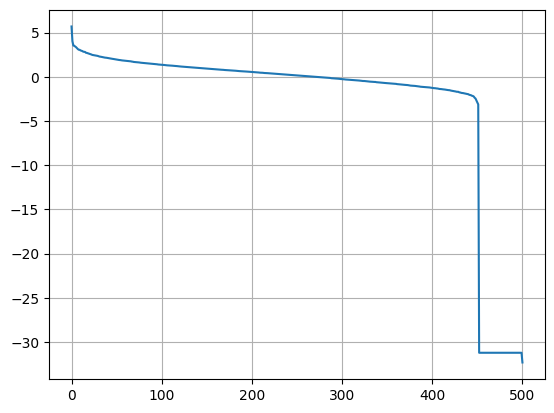

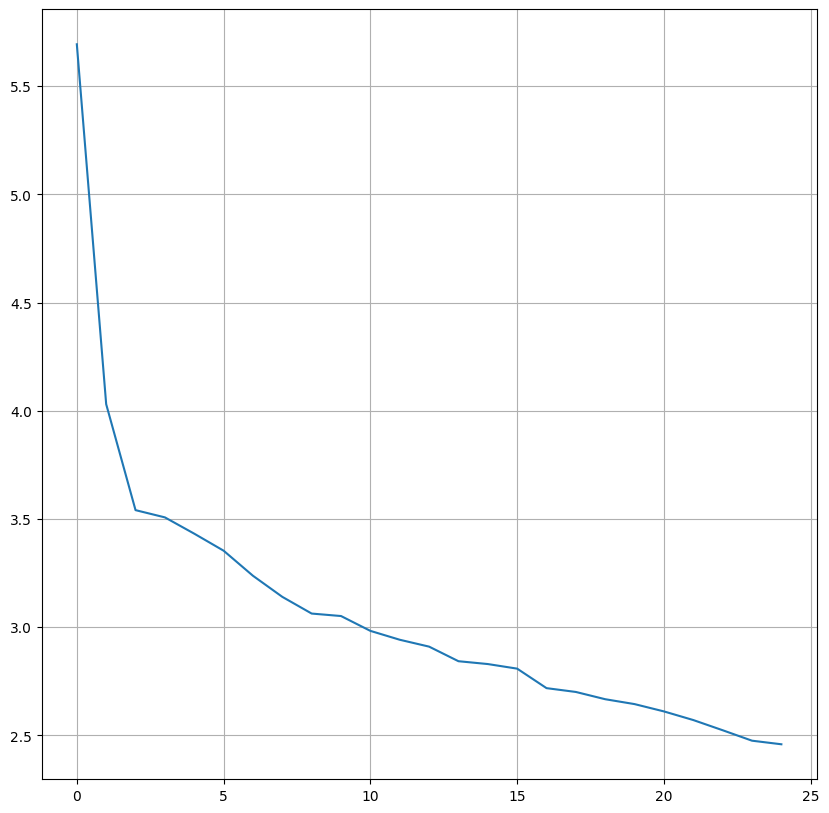

In [13]:
import matplotlib.pyplot as plt

u,s,vh = np.linalg.svd(features)
plt.plot(np.log(s))
#show grid lines
plt.grid()

#zoom in first 25 and make plot bigger

plt.figure(figsize=(10,10))
plt.plot(np.log(s[0:25]))
plt.grid()


In [14]:
pd.DataFrame(u[:,0:20]).to_csv('Feat_REAL_BERT_Description.csv',index=False,header=False) 

print('Finished')  

Finished
